<img style="float: right;" src="http://www2.le.ac.uk/liscb1.jpg">
Scipy is the first place to look for general-purpose scientific functionality.  The Scipy library is enormous and varied, so covering all the features is a course unto itself.  Having said that, one of the most commonly used features in scipy is it's fitting routines, which we will now explore.

## Local minimization

In addition to curve fitting, Scipy provides a number of local (faster,) and global (better,) minimizers.  This allows us to do quite a lot of the parameter finding work we need in science.  If you have a simple problem, especially if you have a decent guess of the final values of the parameters, then local minimization is your tool of choice.  

There are lots of local minimizers, and Scipy give us a single interface to get to several of them:

In [1]:
from scipy.optimize import minimize

First, lets repeat the simple Michaelis-Menten example from notebook 3:

In [2]:
import numpy as np
from matplotlib import pyplot as plt

def michaelis_menten(s, km, vmax):
    return (vmax*s) / (km + s)

substrate_concentrations = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3])
substrate_concentration_range = np.linspace(0, 3, 1000)

km = 0.1
vmax = 0.5

number_of_concentrations = len(substrate_concentrations)
ten_percent_noise = (np.random.normal(loc=0, scale=0.1, size=number_of_concentrations))
simulated_data = michaelis_menten(substrate_concentrations, km, vmax) + ten_percent_noise

mm_curve = michaelis_menten(substrate_concentration_range, km, vmax)

plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_data, label='simulated data', color='green')
plt.legend();

And we re-do the curve fitting:

In [17]:
from scipy.optimize import curve_fit

initial_guess = (1, simulated_data[-1])  # Km and Vmax.  Note the Km is a truly horrible guess, given our data

lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax

fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
print('Km:', fitted[0])
print('Vmax:',fitted[1])

Km: 0.07095063488249088
Vmax: 0.5486249149846236


And plot the results:

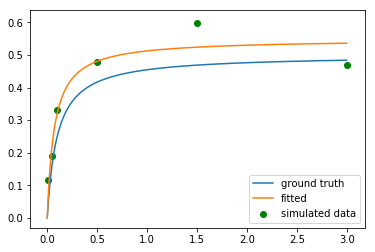

In [18]:
calculated_curve = michaelis_menten(substrate_concentration_range, fitted[0], fitted[1])

plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='fitted')

plt.legend();

If you read the documentation for `curve_fit`, you'll see that it does a non-linear least squares fit.  

In order to do this, we have to construct a function to minimize.  

In this case, we'll minimize the sum-of-squared differences. 
(This is equivalent to optimizing for the mean.  If we minimized the sum of absolute values, we'd be optimizing for the median.) 

In [19]:
def target_function(x, substrate_concentrations, observed_initial_rates):
    '''
    The target function where the first parameter is a sequence of parameters that will be altered to
    achieve the minimum return value
    
    In this example, x will be a 2-tuple with the form (km, vmax)
    '''
    km=x[0]
    vmax=x[1]
    
    calculated_initial_rates = michaelis_menten(substrate_concentrations, km, vmax)
    differences = calculated_initial_rates - observed_initial_rates
    error = sum(differences**2)
    return error


# Sanity check: lets see if the target function gives us a small number when we match the parameters
assert target_function((km, vmax),
                       substrate_concentrations, 
                       michaelis_menten(substrate_concentrations, km, vmax)
                      ) < 0.01

# Sanity check: lets see if the target function give us a big number when we don't match the parameters
assert target_function((km*10, vmax*10),
                       substrate_concentrations, 
                       michaelis_menten(substrate_concentrations, km, vmax)
                      ) > 0.01

Now we do the minimization.  Note that we use the `'SLSQP'` optimizer, as that's the most similar to the one used for curve fitting.  Note also that the bounds are given as tuples of `((min, max), (min, max))`, where they were `((min, min), (max, max))` above.  
This function returns a minimization object with a reasonably informative `__str__`

In [20]:
result = minimize(fun=target_function,  # The function to minimize
                  x0=initial_guess,
                  args=(substrate_concentrations, simulated_data),
                  method='SLSQP',
                  bounds=((0,None), (0,None))
                 )
print(result)

     fun: 0.01394490815342325
     jac: array([-0.00145425, -0.00011152])
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([0.07080249, 0.54845706])


Note that the result is essentially identical to the `curve_fit` above.  This is not surprising as this is essentially how `curve_fit` works.  Note that `curve_fit` is more tolerant to badly chosen starting points than `minimize` is.  Also, notice how much easier `curve_fit` is to use!  

So why use `minimize`?  
It's much more versatile.  You can provide constraints that force parameters to have equality or inequality relationships.  You can have whatever target function you like - which is how 'robust' fitting methods that are tolerant to large outliers work.  You can control the precision of the fit, trading time for accuracy.  You can try different fitting algorithms to find the one best suited to you problem (or match the one used in a paper you're trying to replicate.)  There are in-fact many reasons to use it.

### Exercise 1: Fit the median, not the mean
Change the target function to calculate the sum of absolute value of the difference between the calculated and measured values.  Plot both fits.

     fun: 0.23120452215882106
     jac: array([0.23660182, 0.59987297])
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([0.06308996, 0.53861232])


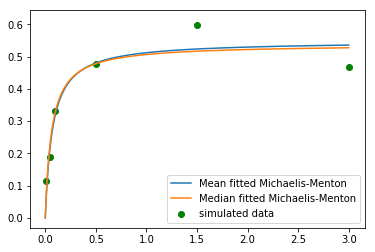

## Global minimization
If you have the time, let the algorithm work out the best overall place to be.  This makes the initial guess of the parameter values much less important.  Watch out, though, you can wait forever (or at least, longer than the age of the universe,) for these to converge if you give them too big a problem.  

We'll look at two algorithms:

In [27]:
from scipy.optimize import basinhopping

This acts as a wrapper around your minimizer, essentially trying many different starting points and finding the best.  
Note that you have to pass a dictionary of the parameters you'd pass to the `minimize` function above.  Increase niter 10 fold until the answer doesn't change.)

In [32]:
basinhopping(func=weighted_target_function,  # The function to minimize
             x0=initial_guess,               # The initial guess
             minimizer_kwargs={'args': (substrate_concentrations, simulated_data),
                               'method': 'SLSQP',
                               'bounds': ((0,None), (0,None))},
             niter=10000
            )

                        fun: 0.23120014646353726
 lowest_optimization_result:      fun: 0.23120014646353726
     jac: array([-2.1146998 ,  0.05028528])
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.0630878 , 0.53860588])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 126951
                        nit: 1000
                       njev: 21717
                          x: array([0.0630878 , 0.53860588])

Alternatively, if you have a good idea of the range of values, but no idea where in that range, try differential evolution.

In [39]:
from scipy.optimize import differential_evolution

differential_evolution(func=weighted_target_function,
                       args=(substrate_concentrations, simulated_data),
                       bounds=((0,10), (0,10))
            )

     fun: 0.23120012989954752
     jac: array([0.16154822, 0.05028327])
 message: 'Optimization terminated successfully.'
    nfev: 990
     nit: 25
 success: True
       x: array([0.06308776, 0.53860581])